In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
local_dir = r"C:\Users\Utente\Downloads\data\\"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [3]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Organization', 'Receiving Organization', 'Participants', 'Field of Education']]
    return df

mobility_df = filter_data(mobility_df)

for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()
        
display(mobility_df)

,Sending Organization,Receiving Organization,Participants,Field of Education
1701,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,ABO AKADEMI,1,Education
1702,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),2,Education
1733,IMC FACHHOCHSCHULE KREMS GMBH,HASKOLINN A BIFROST,1,Business and administration
1734,IMC FACHHOCHSCHULE KREMS GMBH,LAUREA-AMMATTIKORKEAKOULU OY,1,"Travel, tourism and leisure"
1735,IMC FACHHOCHSCHULE KREMS GMBH,METROPOLIA AMMATTIKORKEAKOULU OY,1,"Business, administration and law"
...,...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Political sciences and civics
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3,Pharmacy


In [4]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not further defined','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', inter-disciplinary programmes','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(' not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classifed','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.lower()
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.strip()

In [5]:
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and Humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, J. and I.': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, Admin. and Law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, M. and S.': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'ICTs': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, M. and C.': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, F., F. and V.': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and Welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

In [6]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].apply(standard_field)

In [7]:
fields = ['Education',
'Arts and Humanities',
'Social sciences, J. and I.',
'Business, Admin. and Law',
'Natural sciences, M. and S.',
'ICTs',
'Engineering, M. and C.',
'Agriculture, F., F. and V.',
'Health and Welfare',
'Services']

In [8]:
for i in range(10):
    field = fields[i]
    layer = 'layer'+str(i+1)
    mobility_df[layer] = 0
    mobility_df.loc[mobility_df['Field of Education']==field, layer] = mobility_df[mobility_df['Field of Education']==field]['Participants']
mobility_df

,Sending Organization,Receiving Organization,Participants,Field of Education,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,layer9,layer10
1701,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,ABO AKADEMI,1,Education,1,0,0,0,0,0,0,0,0,0
1702,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),2,Education,2,0,0,0,0,0,0,0,0,0
1733,IMC FACHHOCHSCHULE KREMS GMBH,HASKOLINN A BIFROST,1,"Business, Admin. and Law",0,0,0,1,0,0,0,0,0,0
1734,IMC FACHHOCHSCHULE KREMS GMBH,LAUREA-AMMATTIKORKEAKOULU OY,1,Services,0,0,0,0,0,0,0,0,0,1
1735,IMC FACHHOCHSCHULE KREMS GMBH,METROPOLIA AMMATTIKORKEAKOULU OY,1,"Business, Admin. and Law",0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,"Social sciences, J. and I.",0,0,1,0,0,0,0,0,0,0
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Health and Welfare,0,0,0,0,0,0,0,0,1,0
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Health and Welfare,0,0,0,0,0,0,0,0,1,0
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3,Health and Welfare,0,0,0,0,0,0,0,0,3,0


In [9]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [11]:
scores = {}
for i in range(10):
    layer_df = mobility_df[['Sending Organization','Receiving Organization','SendId','RecId','layer'+str(i+1)]].copy()
    mobility_serie = layer_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(mobility_serie.index.get_level_values(1).tolist())
    col = np.array(mobility_serie.index.get_level_values(0).tolist())
    val = mobility_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    adj_matrix_crs = adj_matrix_crs + adj_matrix_crs.transpose()
    layer_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'layer'+str(i+1):'weight'},axis=1, inplace=True)
    adj_matrix_crs, layer_df, nodes_layer_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), layer_df)

    scores[i] = ns.degree_disribution(adj_matrix_crs, nodes_layer_df, print_graph=False)

In [12]:
for i in range(10):
    scores[i]['Degree'+str(i+1)] = scores[i]['in degree'] + scores[i]['out degree']
    scores[i] = scores[i][['Nodes', 'Degree'+str(i+1)]]

In [13]:
degrees = pd.merge(scores[0], scores[1], on='Nodes', how='outer')
for i in range(2,10):
    degrees = pd.merge(degrees, scores[i], on='Nodes', how='outer')

In [14]:
degrees.fillna(0, inplace=True)
degrees.columns = ['Nodes']+list(np.arange(10))
degrees

,Nodes,0,1,2,3,4,5,6,7,8,9
0,ECOLE DE GESTION ET DE COMMERCE DE RODEZ,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UNIVERSITY OF BIALYSTOK,9.0,2.0,14.0,62.0,12.0,0.0,0.0,0.0,0.0,0.0
2,"SCHOOL OF ORIENTAL AND AFRICAN STUDIES, UNIVER...",7.0,120.0,86.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0
3,DET KONGELIGE DANSKE KUNSTAKADEMIS SKOLER FOR ...,1.0,229.0,0.0,0.0,0.0,1.0,155.0,0.0,0.0,0.0
4,GALATASARAY UNIVERSITY,4.0,211.0,786.0,537.0,27.0,134.0,47.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
7085,DONCASTER COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7086,SVENDBORG INTERNATIONAL MARITIME ACADEMY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7087,UNIVERSITEIT VAN DIE ORANJE VRYSTAAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
7088,NEPAL JESUIT SOCIETY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [15]:
correlation = np.zeros((10,10))
for i in range(10):
    for j in range(i,10):
        mask = ~(degrees[i]*degrees[j]==0)
        deg = degrees[mask]
        r = ((deg[i]*deg[j]).mean() - deg[i].mean()*deg[j].mean()) / (deg[i].std()*deg[j].std())
        correlation[i,j] = r
        correlation[j,i] = r

In [16]:
max = 0
for i in range(10):
    for j in range(10):
        if i != j:
            if correlation[i,j]>max:
                max = correlation[i,j]
print(max)
correlation[correlation>max] = max

0.7425006438418482


In [17]:
corr = pd.DataFrame(correlation)
fields = ['Education',
 'Arts, Humanities',
 'Social sciences',
 'Business, A, L',
 'Natural sciences',
 'ICTs',
 'Engineering, M, C',
 'Agriculture, F, F, V',
 'Health and Welfare',
 'Services']
corr.columns = fields 
corr.index = fields
corr

,Education,"Arts, Humanities",Social sciences,"Business, A, L",Natural sciences,ICTs,"Engineering, M, C","Agriculture, F, F, V",Health and Welfare,Services
Education,0.742501,0.556014,0.503945,0.423171,0.509890,0.280436,0.157083,0.148207,0.544312,0.504448
"Arts, Humanities",0.556014,0.742501,0.742501,0.581073,0.709335,0.340200,0.213899,0.239560,0.634739,0.354474
Social sciences,0.503945,0.742501,0.742501,0.709678,0.686951,0.384404,0.181134,0.250611,0.634675,0.341876
"Business, A, L",0.423171,0.581073,0.709678,0.742501,0.560047,0.404048,0.244857,0.228230,0.551231,0.376822
Natural sciences,0.509890,0.709335,0.686951,0.560047,0.742501,0.524733,0.419076,0.322330,0.644746,0.339480
ICTs,0.280436,0.340200,0.384404,0.404048,0.524733,0.742501,0.736699,0.173017,0.323332,0.328738
"Engineering, M, C",0.157083,0.213899,0.181134,0.244857,0.419076,0.736699,0.742501,0.212967,0.223971,0.205898
"Agriculture, F, F, V",0.148207,0.239560,0.250611,0.228230,0.322330,0.173017,0.212967,0.742501,0.266040,0.153373
Health and Welfare,0.544312,0.634739,0.634675,0.551231,0.644746,0.323332,0.223971,0.266040,0.742501,0.474146
Services,0.504448,0.354474,0.341876,0.376822,0.339480,0.328738,0.205898,0.153373,0.474146,0.742501


<AxesSubplot:>

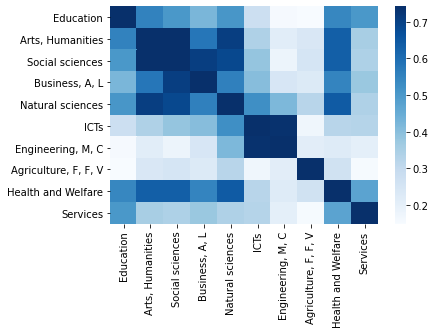

In [18]:
sns.heatmap(corr, cmap="Blues")